# Text Classification

### Preparing Data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
category_lines['Korean'][:10]

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha', 'Chang', 'Chi', 'Chin', 'Cho', 'Choe']

In [3]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [4]:
'''
one-hot vector로 만드는데, 글자 간 상관관계를 알 수 없을 경우에는 직교한다고 가정하고 학습하는 것
'''

import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1 # one-hot vector로 만들어줌
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('K'))

print(lineToTensor('Kim'))
print(lineToTensor('Kim').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

### Network

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
input = lineToTensor('Park')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7800, -3.0161, -2.9502, -2.9057, -2.9272, -2.9564, -2.8380, -2.7859,
         -2.9605, -2.9907, -2.8978, -2.8922, -2.9126, -2.8635, -2.8024, -2.8380,
         -2.7974, -2.9577]], grad_fn=<LogSoftmaxBackward0>)


### Learning

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 0)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Italian / line = Aringheri
category = Vietnamese / line = Chu
category = Italian / line = Sgro
category = Greek / line = Tsoumada
category = Chinese / line = Guo
category = Chinese / line = Song
category = Italian / line = Esposito
category = Vietnamese / line = Vo
category = Italian / line = Rana
category = German / line = Dunst


In [9]:
criterion = nn.NLLLoss()

'''
학습 프로세스
1. 입력과 목표 텐서 생성
2. 0으로 초기화된 은닉상태 생성
3. 문자 읽기
4. loss계산
5. backprop
6. output과 loss 반환
'''

learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

In [10]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s}s'

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else f'✗ {category}'
        print(f'{iter} {iter/n_iters*100} {timeSince(start)} {loss:0.4f} {line} {guess} {correct}')
    
    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5.0 0m 4.202676296234131s 2.6120 Olivier English ✗ French
10000 10.0 0m 8.427706956863403s 0.7115 Karahalios Greek ✓
15000 15.0 0m 12.701871633529663s 2.4331 Milne Italian ✗ Scottish
20000 20.0 0m 16.934882402420044s 0.7096 Shammas Arabic ✓
25000 25.0 0m 21.279381036758423s 1.3058 Do Korean ✗ Vietnamese
30000 30.0 0m 25.598676919937134s 2.1323 Villalobos Portuguese ✗ Spanish
35000 35.0 0m 29.89495277404785s 2.0393 Neisser German ✗ Czech
40000 40.0 0m 34.299335956573486s 2.9095 Piller English ✗ Czech
45000 45.0 0m 38.803391218185425s 0.3962 Kan Chinese ✓
50000 50.0 0m 43.34422588348389s 1.9127 Godden Dutch ✗ English
55000 55.00000000000001 0m 47.77618598937988s 0.9908 Meeuweszen Dutch ✓
60000 60.0 0m 52.231937408447266s 1.6455 Cabral Portuguese ✓
65000 65.0 0m 56.64536261558533s 1.4893 Arreola Portuguese ✗ Spanish
70000 70.0 1m 1.0769681930541992s 0.2527 Yamanoue Japanese ✓
75000 75.0 1m 5.985068082809448s 0.1139 Hatakeyama Japanese ✓
80000 80.0 1m 10.178059577941895s 0.0852 Omelia

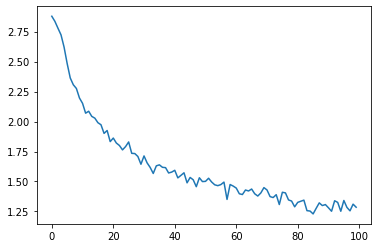

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\OHSEOK~1\AppData\Local\Temp/ipykernel_28248/2814114240.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\OHSEOK~1\AppData\Local\Temp/ipykernel_28248/2814114240.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


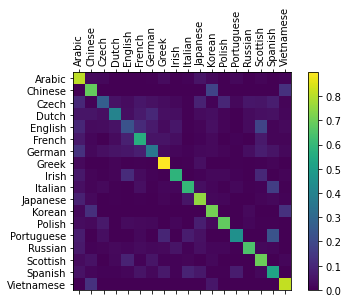

In [12]:
# confusion matrix에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시들 중에 어떤 것이 정확하게 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


In [13]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [25]:
predict('Oh')
predict('Ignazio')
predict('Giuseppe')
predict('Luca')
predict('Jackson')


> Oh
(-0.53) Vietnamese
(-2.17) Korean
(-3.06) Irish

> Ignazio
(-1.36) Spanish
(-1.45) Greek
(-2.10) Russian

> Giuseppe
(-1.04) French
(-1.93) Italian
(-2.04) Dutch

> Luca
(-0.45) Vietnamese
(-2.21) Portuguese
(-2.58) Czech

> Jackson
(-0.07) Scottish
(-3.51) English
(-4.35) Russian
